In [35]:
import pickle
import numpy as np
from scipy.stats import mstats
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [36]:
subjects = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]
random.shuffle(subjects)

numtest = 1 # number of randomly chosen test subjects

testsubjects = subjects[:numtest]
trainsubjects = subjects[numtest:]
print(f"test subjects: {testsubjects}")
print(f"train subjects: {trainsubjects}")

test subjects: [2]
train subjects: [13, 15, 4, 5, 7, 6, 11, 9, 3, 14, 8, 10, 17, 16]


In [37]:
trainwindows = []
testwindows = []

for subject in trainsubjects:

    file_path = f"WESAD/S{subject}/S{subject}.pkl"
    with open(file_path, 'rb') as file:
        data = pickle.load(file, encoding='latin1')
    
    downsampling_factor = {
        "chest/ECG": 10,
        "chest/ACC": 70,
        "chest/EMG": 70,
        "chest/EDA": 200,
        "chest/Temp": 200,
        "chest/Resp": 200,
        "wrist/ACC": 4,
        "wrist/BVP": 1,
        "wrist/EDA": 1,
        "wrist/TEMP": 1,
    }

    #3% winsorization + min-max normalization of signals in data
    def preprocess(arrayobj, device, signal):
        arrayobj = mstats.winsorize(arrayobj, limits = [0.03,0.03])
        arrayobj = arrayobj[::downsampling_factor[f"{device}/{signal}"]]
        min_value, max_value = np.min(arrayobj), np.max(arrayobj)
        arrayobj = (arrayobj - min_value) / (max_value - min_value)
        return arrayobj


    for device in data['signal'].keys():
        for signal in data['signal'][device].keys():
            # print(f"Old range for {device}/{signal}:")
            # print([np.min(data['signal'][device][signal]), np.max(data['signal'][device][signal])])
            data['signal'][device][signal] = preprocess(data['signal'][device][signal], device, signal)
            # print(f"New range for {device}/{signal}:")
            # print([np.min(data['signal'][device][signal]), np.max(data['signal'][device][signal])])
    
    frequencies = {
        "chest/ECG": 70,
        "chest/ACC": 10,
        "chest/EMG": 10,
        "chest/EDA": 3.5,
        "chest/Temp": 3.5,
        "chest/Resp": 3.5,
        "wrist/ACC": 8,
        "wrist/BVP": 64,
        "wrist/EDA": 4,
        "wrist/TEMP": 4,
        
    }

    # labels are collected at frequency of 700, so we are looking to divide into windows of 60 * 700 and steps of 30 * 700 Hz

    labelfreq = 700
    # in seconds
    windowsize = 60
    windowstep = 30

    for i in range((len(data["label"]) // (windowstep * labelfreq)) - 2):
        datawindow = {}
        datawindow['signal'] = {}
        for device in data['signal'].keys():
            datawindow['signal'][device] = {}
            for signal in data['signal'][device].keys():
                

                fkey = f"{device}/{signal}"
                datawindow['signal'][device][signal] = np.array(data['signal'][device][signal][int(i * frequencies[fkey] * windowstep):int(i * frequencies[fkey] * windowstep + frequencies[fkey] * windowsize)])
        # print(i)
        
        labels = data['label'][int(i * labelfreq * windowstep): int(i * labelfreq * windowstep + windowsize * labelfreq)]
        # print(labels)
        # print(np.bincount(labels))
        label = np.bincount(labels).argmax() # finds the most common element of an integer array
        
        datawindow['label'] = label
        if (label in [0, 4, 5, 6, 7]): # ignoring labels 0, 5, 6, 7. May consider removing label 4 as well, as I usually do not see meditation considered.
            continue


        datawindow['subject'] = data['subject']
        trainwindows.append(datawindow)
    print("done")
    
with open(f'{trainsubjects}.pkl', 'wb') as file:
    pickle.dump(trainwindows, file)

print(f"List has been pickled and saved to '{trainsubjects}.pkl'.")




for subject in testsubjects:

    file_path = f"WESAD/S{subject}/S{subject}.pkl"
    with open(file_path, 'rb') as file:
        data = pickle.load(file, encoding='latin1')
    
    downsampling_factor = {
        "chest/ECG": 10,
        "chest/ACC": 70,
        "chest/EMG": 70,
        "chest/EDA": 200,
        "chest/Temp": 200,
        "chest/Resp": 200,
        "wrist/ACC": 4,
        "wrist/BVP": 1,
        "wrist/EDA": 1,
        "wrist/TEMP": 1,
    }

    #3% winsorization + min-max normalization of signals in data
    def preprocess(arrayobj, device, signal):
        arrayobj = mstats.winsorize(arrayobj, limits = [0.03,0.03])
        arrayobj = arrayobj[::downsampling_factor[f"{device}/{signal}"]]
        min_value, max_value = np.min(arrayobj), np.max(arrayobj)
        arrayobj = (arrayobj - min_value) / (max_value - min_value)
        return arrayobj


    for device in data['signal'].keys():
        for signal in data['signal'][device].keys():
            # print(f"Old range for {device}/{signal}:")
            # print([np.min(data['signal'][device][signal]), np.max(data['signal'][device][signal])])
            data['signal'][device][signal] = preprocess(data['signal'][device][signal], device, signal)
            # print(f"New range for {device}/{signal}:")
            # print([np.min(data['signal'][device][signal]), np.max(data['signal'][device][signal])])
    
    frequencies = {
        "chest/ECG": 70,
        "chest/ACC": 10,
        "chest/EMG": 10,
        "chest/EDA": 3.5,
        "chest/Temp": 3.5,
        "chest/Resp": 3.5,
        "wrist/ACC": 8,
        "wrist/BVP": 64,
        "wrist/EDA": 4,
        "wrist/TEMP": 4,
        
    }

    # labels are collected at frequency of 700, so we are looking to divide into windows of 60 * 700 and steps of 30 * 700 Hz

    labelfreq = 700
    # in seconds
    windowsize = 60
    windowstep = 30

    for i in range((len(data["label"]) // (windowstep * labelfreq)) - 2):
        datawindow = {}
        datawindow['signal'] = {}
        for device in data['signal'].keys():
            datawindow['signal'][device] = {}
            for signal in data['signal'][device].keys():
                

                fkey = f"{device}/{signal}"
                datawindow['signal'][device][signal] = np.array(data['signal'][device][signal][int(i * frequencies[fkey] * windowstep):int(i * frequencies[fkey] * windowstep + frequencies[fkey] * windowsize)])
        # print(i)
        
        labels = data['label'][int(i * labelfreq * windowstep): int(i * labelfreq * windowstep + windowsize * labelfreq)]
        # print(labels)
        # print(np.bincount(labels))
        label = np.bincount(labels).argmax() # finds the most common element of an integer array
        
        datawindow['label'] = label
        if (label in [0, 4, 5, 6, 7]): # ignoring labels 0, 5, 6, 7. May consider removing label 4 as well, as I usually do not see meditation considered.
            continue


        datawindow['subject'] = data['subject']
        testwindows.append(datawindow)
    print("done")
    
with open(f'{testsubjects}.pkl', 'wb') as file:
    pickle.dump(testwindows, file)

print(f"List has been pickled and saved to '{testsubjects}.pkl'.")

done
done
done
done
done
done
done
done
done
done
done
done
done
done
List has been pickled and saved to '[13, 15, 4, 5, 7, 6, 11, 9, 3, 14, 8, 10, 17, 16].pkl'.
done
List has been pickled and saved to '[2].pkl'.


In [38]:
train_path = f'{trainsubjects}.pkl'
test_path = f'{testsubjects}.pkl'

with open(train_path, 'rb') as file:
    trainwindows = pickle.load(file, encoding='latin1')

random.shuffle(trainwindows)

with open(test_path, 'rb') as file:
    testwindows = pickle.load(file, encoding='latin1')

random.shuffle(testwindows)

In [39]:
trainX = trainwindows
testX = testwindows

trainY = np.zeros(len(trainX))
for i, window in enumerate(trainX):
    trainY[i] = trainX[i]['label']
    # print(trainY[i])

testY = np.zeros(len(testX))
for i, window in enumerate(testX):
    testY[i] = testX[i]['label']

trainY = trainY - 1
testY = testY - 1
trainY = torch.tensor(trainY, dtype = torch.long)
testY = torch.tensor(testY, dtype = torch.long)


print(trainY)
print(len(trainY))
print(len(testY))

tensor([1, 1, 0,  ..., 0, 2, 2])
1034
71


In [40]:


class MultiSignalLSTMnoACC(nn.Module):
    def __init__(self, input_dim_1, input_dim_2, input_dim_3, input_dim_4, input_dim_5, input_dim_6, input_dim_7, input_dim_8, num_classes=3):
        super(MultiSignalLSTMnoACC, self).__init__()

        hidden_dim = 64
        # LSTM Branch for Signal 1
        
        self.lstm1 = nn.LSTM(input_size=input_dim_1, hidden_size=hidden_dim, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=input_dim_2, hidden_size=hidden_dim, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=input_dim_3, hidden_size=hidden_dim, batch_first=True)
        self.lstm4 = nn.LSTM(input_size=input_dim_4, hidden_size=hidden_dim, batch_first=True)
        self.lstm5 = nn.LSTM(input_size=input_dim_5, hidden_size=hidden_dim, batch_first=True)
        self.lstm6 = nn.LSTM(input_size=input_dim_6, hidden_size=hidden_dim, batch_first=True)
        self.lstm7 = nn.LSTM(input_size=input_dim_7, hidden_size=hidden_dim, batch_first=True)
        self.lstm8 = nn.LSTM(input_size=input_dim_8, hidden_size=hidden_dim, batch_first=True)

        # Fully connected layers
        total_hidden_size = hidden_dim * 8  # 8 signals, each with hidden_dim output
        # Fully connected layers
        self.fc1 = nn.Linear(total_hidden_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)

    def forward(self, datawindow):
        signal = []
        for device in datawindow["signal"]:
            for s in datawindow["signal"][device]:
                if (s != "ACC"): # excluding ACC for now.
                    signal.append(np.zeros((len(datawindow["signal"][device][s]))))
                    for i in range(len(datawindow["signal"][device][s])):
                        signal[-1][i] = datawindow["signal"][device][s][i]
                    signal[-1] = torch.from_numpy(signal[-1]).float().unsqueeze(0).unsqueeze(0)
                        
        # print(signal)



        # Pass each signal through its respective CNN branch
        _, (h1, _) = self.lstm1(signal[0])
        _, (h2, _) = self.lstm2(signal[1])
        _, (h3, _) = self.lstm3(signal[2])
        _, (h4, _) = self.lstm4(signal[3])
        _, (h5, _) = self.lstm5(signal[4])
        _, (h6, _) = self.lstm6(signal[5])
        _, (h7, _) = self.lstm7(signal[6])
        _, (h8, _) = self.lstm8(signal[7])

        # Concatenate the features from each branch
        combined = torch.cat((h1[-1], h2[-1], h3[-1], h4[-1], h5[-1], h6[-1], h7[-1], h8[-1]), dim=1)

        # Pass through fully connected layers
        x = torch.relu(self.fc1(combined))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)

        # x = torch.softmax(x, dim=1) # use only if not using cross entropy loss

        return x



In [41]:
len(trainX[0]['signal']['chest']['ACC'])

600

In [42]:
input_dim_1 = 4200
input_dim_2 = 600
input_dim_3 = 210
input_dim_4 = 210
input_dim_5 = 210
input_dim_6 = 3840
input_dim_7 = 240
input_dim_8 = 240
num_classes = 3

model = MultiSignalLSTMnoACC(input_dim_1=input_dim_1, input_dim_2=input_dim_2, input_dim_3=input_dim_3, input_dim_4=input_dim_4, input_dim_5=input_dim_5, input_dim_6=input_dim_6, input_dim_7=input_dim_7, input_dim_8=input_dim_8, num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 1 # probably will break if you change this as of rn.
num_epochs = 15

train_accuracies = []
test_accuracies = []
train_loss = []
test_loss = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Shuffle data at the beginning of each epoch (optional but recommended)
    indices = torch.randperm(len(trainY))

    correct = 0
    total = 0

    for i in range(0, len(trainY), batch_size):
        batch_indices = indices[i:i + batch_size]
        
        # Extract batch data
        batch_data = trainX[batch_indices]
        batch_labels = trainY[batch_indices]

        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch_data)
        
        # Compute loss
        loss = criterion(outputs, batch_labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * len(batch_labels)

        _, predicted = torch.max(outputs, 1)
        total += batch_size
        correct += (predicted == batch_labels).sum().item()

    epoch_loss = running_loss / len(trainY)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {100 * correct / total:.2f}%, ({correct} / {total})")
    train_loss.append(epoch_loss)
    train_accuracies.append(100 * correct / total)
    
    model.eval()
    with torch.no_grad():
        
        running_loss = 0.0

        indices = torch.randperm(len(testY))

        correct = 0
        total = 0
        for i in range(0, len(testY), batch_size):
            batch_indices = indices[i: i + batch_size]
            batch_data = testX[batch_indices]
            batch_labels = testY[batch_indices]
            
            outputs = model(batch_data)

            loss = criterion(outputs, batch_labels)
            running_loss += loss.item() * len(batch_labels)


            _, predicted = torch.max(outputs, 1)
            total += batch_size
            correct += (predicted == batch_labels).sum().item()
            
    epoch_loss = running_loss / len(testY)
    print(f"Test Loss: {epoch_loss:.4f}, Test Accuracy: {100 * correct / total:.2f}%, ({correct} / {total})")
    test_loss.append(epoch_loss)
    test_accuracies.append(100 * correct / total)

/var/folders/l5/_r8k9ngs78vf65dr9lg59n7c0000gp/T/ipykernel_70800/3471232371.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  signal[-1][i] = datawindow["signal"][device][s][i]


Epoch 1/15, Loss: 0.5436, Accuracy: 79.01%, (817 / 1034)
Test Loss: 0.7267, Test Accuracy: 63.38%, (45 / 71)
Epoch 2/15, Loss: 0.4304, Accuracy: 84.43%, (873 / 1034)
Test Loss: 0.9414, Test Accuracy: 67.61%, (48 / 71)
Epoch 3/15, Loss: 0.4196, Accuracy: 85.01%, (879 / 1034)
Test Loss: 0.5593, Test Accuracy: 76.06%, (54 / 71)
Epoch 4/15, Loss: 0.3783, Accuracy: 85.78%, (887 / 1034)
Test Loss: 0.7037, Test Accuracy: 67.61%, (48 / 71)
Epoch 5/15, Loss: 0.3660, Accuracy: 84.82%, (877 / 1034)
Test Loss: 1.1323, Test Accuracy: 64.79%, (46 / 71)
Epoch 6/15, Loss: 0.3632, Accuracy: 85.59%, (885 / 1034)
Test Loss: 0.6352, Test Accuracy: 70.42%, (50 / 71)
Epoch 7/15, Loss: 0.3329, Accuracy: 87.04%, (900 / 1034)
Test Loss: 0.8687, Test Accuracy: 69.01%, (49 / 71)
Epoch 8/15, Loss: 0.3264, Accuracy: 86.27%, (892 / 1034)
Test Loss: 0.7767, Test Accuracy: 71.83%, (51 / 71)
Epoch 9/15, Loss: 0.3096, Accuracy: 87.43%, (904 / 1034)
Test Loss: 0.6678, Test Accuracy: 71.83%, (51 / 71)
Epoch 10/15, Loss: 

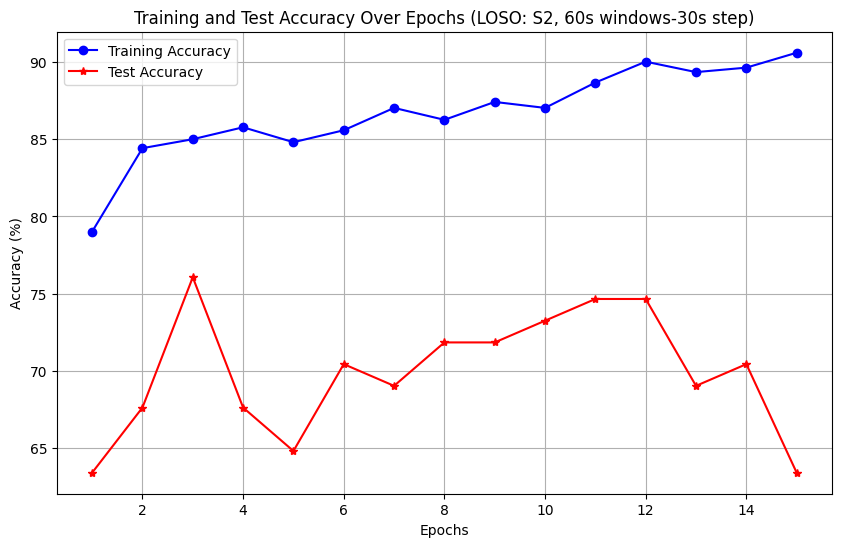

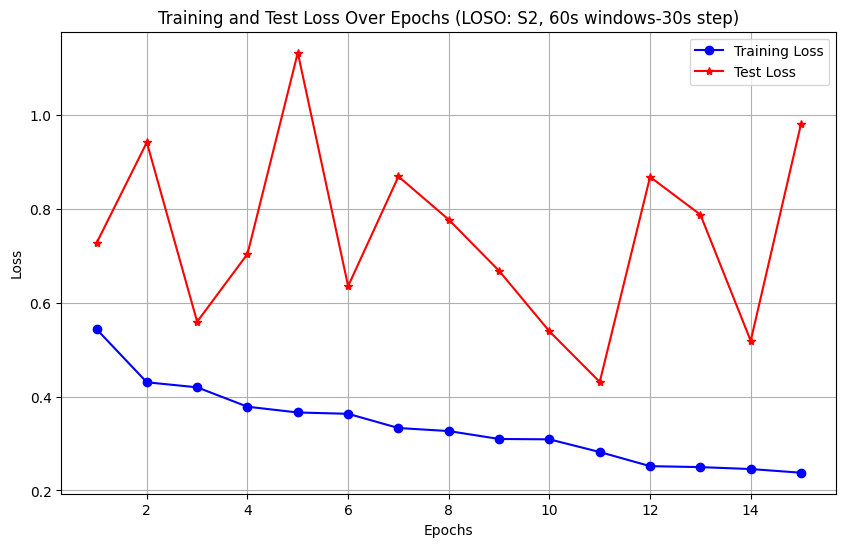

In [43]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
plt.plot(epochs, test_accuracies, 'r*-', label='Test Accuracy')
plt.title(f'Training and Test Accuracy Over Epochs (LOSO: S{testsubjects[0]}, 60s windows-30s step)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, test_loss, 'r*-', label='Test Loss')
plt.title(f'Training and Test Loss Over Epochs (LOSO: S{testsubjects[0]}, 60s windows-30s step)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
